# Computer Vision - P6

### **Carefully read the file `README.md` as well as the following instructions before start coding.**

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): January 5th, 23:00 h** 

## Haar-like features applied for face detection

Today's exercices will practise the following:

- Integral images and a classical use for fast harr-like feature computation.
 - Use of Adaboost for classification.
- Decisions based on a user-defined threshold for balancing precision and recall.

In [1]:
# Some useful imports for the exercises
import numpy as np
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt

%matplotlib inline

**1) Build a function `to_integral_image` that computes the integral image of an input (2D) array.**

The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

```python
 def to_integral_image(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    # Add here code
    
    return integral_image_arr
```


You can make the following tests:
 
 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 
Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```




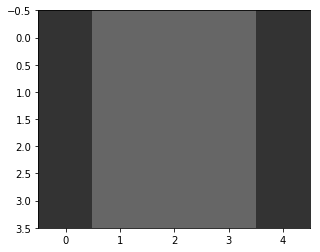

In [2]:
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
img_array.shape
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)

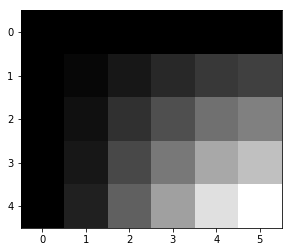

True
True


In [3]:
def to_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    for i in range (0, img_arr.shape[0]):
        for j in range (0, img_arr.shape[1]):
            
            # Add union of integral image values at i-1 and j-1
            integral_image_arr[i+1, j+1] = (integral_image_arr[i, j+1] 
            + integral_image_arr[i+1, j]
            - integral_image_arr[i, j]
            + img_arr[i, j])
    
    return integral_image_arr

integral = to_integral_image(img_array)

plt.imshow(integral, cmap="gray")
plt.show()

# Comprovacions
print(np.sum(img_array) == integral[-1,-1])
print(img_array[0,:].sum() == integral[1,-1])

** 2) Build a function to compute the  sum of the pixel intensities within a  rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.**

Make the function with the following header:
```
def sum_region(integral_img_arr, top_left, bottom_right):
```


In [77]:
def sum_region(integral_img_arr, top_left, bottom_right):
    """
    Calculate sum of pixel intensities in the rectangle comprised between top_left and bottom_right
    """
    
    bottom_left = [bottom_right[0], top_left[1]]
    top_right = [top_left[0], bottom_right[1]]
    
    result = (integral_img_arr[bottom_right[0], bottom_right[1]] 
              - integral_img_arr[top_right[0], top_right[1]] 
              - integral_img_arr[bottom_left[0], bottom_left[1]]
              + integral_img_arr[top_left[0], top_left[1]])
    
    return result

In [78]:
# result you should get (12)
sum_region(integral, [1,1],[3,4])

12.0

In [53]:
# result you should get (32)
sum_region(integral, [0,0],[-1,-1])

[0, 0] (0, -1) (-1, 0) [-1, -1]


32.0

**3) Compute the integral image for all the following images:**
    
- training images of faces: save results in **`faces_ii_training`**
- testing images of face: save the results in **`faces_ii_testing`**
- training images of non faces: **`non_faces_ii_training`**
- testing images of non faces:  **`non_faces_ii_testing`**

To do so build a function to read all the images inside a given folder:

```python
def load_images(path):
    images = []
    for _file in os.listdir(path):
       #### Read image
       #### Remember to scale the image (wih the max pixel intensity value)
     
    return images
 ```

In [7]:
pos_training_path = 'trainingdata/faces'
neg_training_path = 'trainingdata/nonfaces'
pos_testing_path = 'trainingdata/faces/test'
neg_testing_path = 'trainingdata/nonfaces/test'

In [8]:
def load_images(path):
    
    images = []
    
    # Parse all files in the defined directory
    # and retrieve those with a png extension
    for file in os.listdir(path):
        if file.endswith(".png"):
            
            # Open image access
            img = Image.open(path + "/" + file)
            
            # Convert image to numpy array
            img_arr = np.array(img)
            
            # Normalize array
            img_arr = img_arr / np.max(img_arr)
            
            # Compute integral image and store in images array
            images.append(to_integral_image(img_arr))
            
            # Close image access
            img.close()
    
    return images

integral_images = load_images(pos_training_path)

**4) Compute the Haar features of an image**

The code given will use the  `sum_region` function you have implemented to compute Haar-like features.
The following code, for example, will compute a vertical Haar-like feature
```python
    first = sum_region(int_img, 
                      self.top_left, 
                      (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
    second = sum_region(int_img, 
                       (self.top_left[0], int(self.top_left[1] + self.height / 2)),
                       self.bottom_right)
    score = first - second
```

We provide you with `HaarLikeFeature` class that has build in a `get_score` function and a `get_vote` function.

Your job is to 
```python
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                
                
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features
```

In [9]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: violajonse.HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)


In [25]:

def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    :return: List of selected features
    :rtype: list[violajones.HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=None)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))
    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')


    return classifiers

def _get_feature_vote(feature, image):
    return feature.get_vote(image)

def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                
                # Iterate over image applying feature
                for i in range(img_width - feature_width):
                    for j in range(img_height - feature_height):
                        
                        # Create new feature at this position
                        new_feature_p = HaarLikeFeature(feature, (i, j), feature_width, feature_height, 0, 1)
                        new_feature_n = HaarLikeFeature(feature, (i, j), feature_width, feature_height, 0, -1)
                        
                        # Append created features to list
                        features.append(new_feature_p)
                        features.append(new_feature_n)
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features


** 5)Use the learn method  to learn a list of classifiers with the train data **

With the `learn` function you can build a list of classifiers that detect whether an image contains a face or not.

Use the following hyperparameters of the features and `num_classifiers`.

In [20]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [115]:
# Train images
integral_images_faces = load_images(pos_training_path)
integral_images_nonfaces = load_images(neg_training_path)

# Test images
integral_test_faces = load_images(pos_testing_path)
integral_test_nonfaces = load_images(neg_testing_path)

/Users/lluismontabes/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [26]:
%%time 
classifiers = learn(integral_images_faces[:100], integral_images_nonfaces, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.0424809455871582
Calculating scores for images..
0 / 200
1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200
9

** 6) Make a function for voting with different classifiers **

Build two functions `ensemble_vote` and `ensemble_vote_all`.

- `ensemble_vote(int_img, classifiers)` has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise

- `ensemble_vote_all(int_imgs, classifiers)` has to loop over the list `int_imgs` and compute the `ensemble_vote` for each image in the list. It has to return a list containing all the votes for all the images in  `int_imgs`.

Use the functions to compute the train and test acurracies for faces and non faces.

Print the results in the following format:
```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [127]:
def ensemble_vote(int_img, classifiers):
    
    total = 0

    # For each classifier...
    for c in classifiers:

        # Compute vote for this image given the current classifier
        total += c.get_vote(int_img)
    
    return 1 if (total > 0) else 0

In [128]:
faces_vote = ensemble_vote(integral_images_faces[0], classifiers)
nonfaces_vote = ensemble_vote(integral_images_nonfaces[0], classifiers)

print ("Ensembled vote for test face:", faces_vote)
print ("Ensembled vote for test non-face:", nonfaces_vote)

Ensembled vote for test face: 1
Ensembled vote for test non-face: 1


In [126]:
# Solution 1
def ensemble_vote_all(int_imgs, classifiers):
    
    votes = []
    
    # For each image in the array...
    for img in int_imgs:
        
        # Retrieve ensemble_vote of image given classifiers
        votes.append(ensemble_vote(img, classifiers))
    
    return votes

In [125]:
print ("Ensembled votes for face collection sample:", ensemble_vote_all(integral_images_faces[:100], classifiers))
print ("Ensembled votes for non-face collection sample:", ensemble_vote_all(integral_images_nonfaces[:100], classifiers))

Ensembled votes for face collection sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Ensembled votes for non-face collection sample: [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]


In [129]:
def compute_accuracy(collections, classifiers):
    """
    Compute accuracy of given classifiers using
    positive and negative image collections
    """
    
    # Iterate over collections of images.
    # This will contain the 'train' and 'test' collections
    for collection_name, collection_images in collections.items():
    
        positive_imgs, negative_imgs = collection_images
    
        # Retrieve ensembled votes for positive and negative images 
        positive_votes = ensemble_vote_all(positive_imgs, classifiers)
        negative_votes = ensemble_vote_all(negative_imgs, classifiers)

        # Compute how many of the ensembled votes were correctly identified
        positive_correct = positive_votes.count(1)
        negative_correct = negative_votes.count(0)

        # Print accuracy statistics for current collection
        print (collection_name, "results:")
        print ("Correctly identified Faces: {0}/{1}  ({2}%)"
               .format(positive_correct, len(positive_votes), positive_correct * 100 / len(positive_votes)))
        print ("Correctly identified non-Faces: {0}/{1}  ({2}%)\n"
               .format(negative_correct, len(negative_votes), negative_correct * 100 / len(negative_votes)))

In [124]:
collections = {"train" : (integral_images_faces, integral_images_nonfaces),
              "test" : (integral_test_faces, integral_test_nonfaces)}

compute_accuracy(collections, classifiers)

train results:
Correctly identified Faces: 2370/2429  (97.57101687937423%)
Correctly identified non-Faces: 3316/8548  (38.79270004679457%)

test results:
Correctly identified Faces: 349/472  (73.94067796610169%)
Correctly identified non-Faces: 57/128  (44.53125%)



** 7) Make another test with 20 classifiers instead of 2**

Inspect the classification results if you use adaboost with 20 classifiers. Use the same hyperameters for the features.
Print the results as in the previous exercise:

```
train results:
Correctly identified Faces: 2256/2429  (92.87772745986003%)
Correctly identified non-Faces: 7046/8548  (82.42863827795975%)

test results:
Correctly identified Faces: 285/472  (60.381355932203384%)
Correctly identified non-Faces: 104/128  (81.25%)
```

- Do the classification results improved in the train data?



In [130]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [131]:
%%time 
classifiers = learn(integral_images_faces, integral_images_nonfaces[:100], num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.058767080307006836
Calculating scores for images..
0 / 200
1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200

In [137]:
compute_accuracy(collections, classifiers)

train results:
Correctly identified Faces: 2170/2429  (89.33717579250721%)
Correctly identified non-Faces: 6800/8548  (79.55077211043519%)

test results:
Correctly identified Faces: 273/472  (57.83898305084746%)
Correctly identified non-Faces: 107/128  (83.59375%)



**QUESTIONS**

**Q: Do the classification results improved in the train data?**

**A:** Contrasting these new results with the ones obtained using only 2 classifiers, we can see how our algorithm became stricter: the amount of false positives decreased in exchange of the amount of true positives decreasing slightly.

** 8) Change the voting functions so that you can set a threshold for deciding a prediction**

The threshold value indicates the minimum score for assigning a "positive" label (detect a face).

Create the following functions

- `ensemble_vote_t`: returns the final decision of a list of classifiers for a given threshold.
- `ensemble_vote_all_t`: Iterates over a list of integral images and returns the  final decision of a list of classifiers for each of the images (for a given threshold).



compute the following:

- a) number of correct faces over all faces (in the train data)
- b) number of correct non faces over all non faces (in the train data)
- c) number of correct faces over all faces (in the test data)
- d) number of correct non faces over all non faces (in the test data)

Using the list of 20 classifiers.


The quantities have to be computed for each of the following thresholds:

```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

- Make a bar bar plot for a) b) c) and d). In the x axis write the threshold value. 

- What happens when you increase the threshold value ?

In [136]:
thresholds = np.array([x for x in range(-5,5,1)])/10.

In [134]:
correct_faces_train_t = []
correct_non_faces_train_t = []
correct_faces_test_t = []
correct_non_faces_test_t = []

In [164]:
def ensemble_score(int_img, classifiers):
    return sum([c.get_vote(int_img) for c in classifiers])

def ensemble_vote_t(int_img, classifiers, t):
    
    # Compute score and return 1 if score is higher than threshold
    score = ensemble_score(int_img, classifiers)
    return 1 if (score > t) else 0

def ensemble_vote_all_t(int_imgs, classifiers, t=-0.1):
    votes = []
    
    # Compute vote for each image given threshold
    for img in int_imgs:
        votes.append(ensemble_vote_t(img, classifiers, t))
    
    return votes

In [172]:
def compute_accuracy_t(collections, classifiers, t):
    """
    Compute accuracy of given classifiers using
    positive and negative image collections given
    a threshold value
    """
    
    result = {}
    
    # Iterate over collections of images.
    # This will contain the 'train' and 'test' collections
    for collection_name, collection_images in collections.items():
    
        positive_imgs, negative_imgs = collection_images
    
        # Retrieve ensembled votes for positive and negative images 
        positive_votes = ensemble_vote_all_t(positive_imgs, classifiers, t)
        negative_votes = ensemble_vote_all_t(negative_imgs, classifiers, t)

        # Compute how many of the ensembled votes were correctly identified
        positive_correct = positive_votes.count(1)
        negative_correct = negative_votes.count(0)

        result[collection_name] = (positive_correct / len(positive_votes), negative_correct / len(negative_votes))

    return result

In [173]:
compute_accuracy_t(collections, classifiers, -.1)

{'train': (0.8983120625771922, 0.7835751052877866),
 'test': (0.597457627118644, 0.828125)}

In [177]:
values = [compute_accuracy_t(collections, classifiers, t) for t in thresholds]

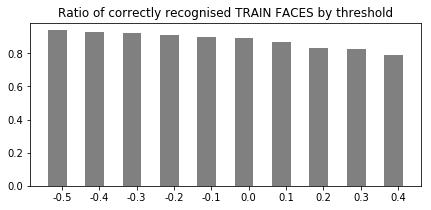

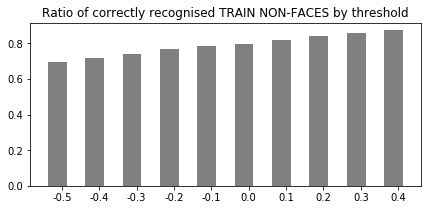

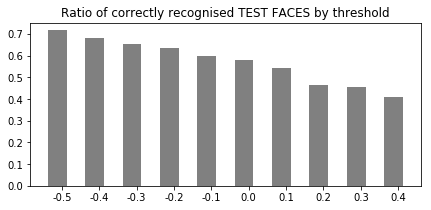

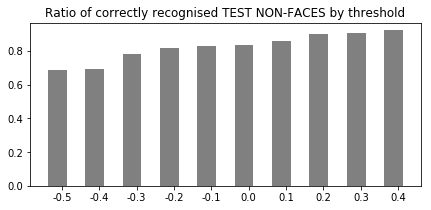

In [251]:
correct_faces_train_t = [d['train'][0] for d in values]
correct_non_faces_train_t = [d['train'][1] for d in values]
correct_faces_test_t = [d['test'][0] for d in values]
correct_non_faces_test_t = [d['test'][1] for d in values]

accuracy_values = {
    'train faces' : correct_faces_train_t, 
    'train non-faces' : correct_non_faces_train_t, 
    'test faces' : correct_faces_test_t, 
    'test non-faces' : correct_non_faces_test_t
}

for name, v in accuracy_values.items():
    
    # Generate bar graph
    fig = plt.figure(figsize = (7, 3))
    ax = fig.add_subplot(111)

    # Specify bar width and range of X values
    # histogram[1] contains the values of the bins - therefore our X axis is in the range (0, len(histogram[1]))
    width = 1 / 2
    x_range = np.arange(len(thresholds))
    
    ax.set_xticks(x_range + width / 4)
    ax.set_xticklabels(thresholds)

    # In case image has color channels, retrieve histogram data for 
    # each and add to displayed graph.

    rects = ax.bar(x_range, v, width, color='grey')
    
    ax.set_title("Ratio of correctly recognised {0} by threshold".format(name.upper()))
    plt.show(ax)

**QUESTIONS**

**Q: What happens when you increase the threshold value?**

**A:** Examining the graphs above, it is easy to identify a tendecy: the higher the threshold, the fewer faces we'll recognize altogether. Even though this decreases the amount of false positives dramatically, it also sacrifices a lot of potential valid detections. 

A practical approach would be to optimize our threshold in order to, given a set of requirements for the scenario in which we're trying to detect faces, comply with an acceptable amount of false positives and false negatives.